# Convolutional Tsetlin Machine

## Setup

In [ ]:
import os
import sys
import numpy as np
from pathlib import Path

In [ ]:
# Detect Colab if present
try:
    from google.colab import drive
    COLAB = True
    print("Note: Using Google CoLab")
except:
    print("Note: Not using Google CoLab")
    COLAB = False

if COLAB:
    if not os.path.ismount("/content/drive"):
        print("Note: Mounting drive")
        drive.mount('/content/drive')
    else:
        print("Note: Drive already mounted")

    os.system("pip install pycm")
    print("Note: pycm installed")
    os.system("pip install pyTsetlinMachine")
    print("Note: pyTsetlinMachine")

    sys.path.append("/content/drive/MyDrive/tumorclass.info")
    sys.path.append("/content/drive/MyDrive/tumorclass.info/notebooks")

    PROJECT_PATH = "/content/drive/MyDrive/tumorclass.info"

else:
    PROJECT_PATH = str(Path.cwd().parent)

DATA_PATH = os.path.join(PROJECT_PATH, "data/")
MODELS_PATH = os.path.join(PROJECT_PATH, "models/")
DATASET_PATH = os.path.join(PROJECT_PATH, "data/dataset/")
SRC_0_PATH = os.path.join(PROJECT_PATH, "data/dataset/src_0/")
SRC_1_PATH = os.path.join(PROJECT_PATH, "data/dataset/src_1/")
SRC_2_PATH = os.path.join(PROJECT_PATH, "data/dataset/src_2/")
TRAIN_PATH = os.path.join(PROJECT_PATH, "data/dataset/train/")
TRAIN_NORMAL_PATH = os.path.join(PROJECT_PATH, "data/dataset/train/normal/")
TRAIN_LGG_PATH = os.path.join(PROJECT_PATH, "data/dataset/train/lgg/")
TRAIN_HGG_PATH = os.path.join(PROJECT_PATH, "data/dataset/train/hgg/")
TEST_PATH = os.path.join(PROJECT_PATH, "data/dataset/test/")
TEST_NORMAL_PATH = os.path.join(PROJECT_PATH, "data/dataset/test/normal/")
TEST_LGG_PATH = os.path.join(PROJECT_PATH, "data/dataset/test/lgg/")
TEST_HGG_PATH = os.path.join(PROJECT_PATH, "data/dataset/test/hgg/")
VALID_PATH = os.path.join(PROJECT_PATH, "data/dataset/valid/")
VALID_NORMAL_PATH = os.path.join(PROJECT_PATH, "data/dataset/valid/normal/")
VALID_LGG_PATH = os.path.join(PROJECT_PATH, "data/dataset/valid/lgg/")
VALID_HGG_PATH = os.path.join(PROJECT_PATH, "data/dataset/valid/hgg/")
AUG_TRAIN_PATH = os.path.join(PROJECT_PATH, "data/dataset/aug_train/")
AUG_TRAIN_NORMAL_PATH = os.path.join(
    PROJECT_PATH, "data/dataset/aug_train/normal/"
)
AUG_TRAIN_LGG_PATH = os.path.join(PROJECT_PATH, "data/dataset/aug_train/lgg/")
AUG_TRAIN_HGG_PATH = os.path.join(PROJECT_PATH, "data/dataset/aug_train/hgg/")

try:
    TEST_NORMAL_FILES = np.array(sorted(os.listdir(TEST_NORMAL_PATH)))
    TEST_LGG_FILES = np.array(sorted(os.listdir(TEST_LGG_PATH)))
    TEST_HGG_FILES = np.array(sorted(os.listdir(TEST_HGG_PATH)))
except FileNotFoundError:
    print("Note: No test data found! Run preprocessing.ipynb first.")

In [ ]:
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    f1_score,
    precision_score,
    recall_score,
)
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.backend import clear_session
from tensorflow.keras.callbacks import (
    EarlyStopping,
    LearningRateScheduler,
    ModelCheckpoint,
    ReduceLROnPlateau,
)
from tensorflow.keras.layers import Dense, Input, AveragePooling2D, Flatten, Dropout
from tensorflow.keras.models import Model, Sequential, load_model, save_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tools.data import (
    compare_predictions,
    confusion_matrix,
    count_params,
    enumerate_oxford,
    learning_rate_scheduler,
    p_join,
    predict_gen,
    predictor,
)
from tools.file import mkdir_if_not_exists, pickler
from tools.visualize import plot_batch, plot_epochs

In [ ]:
MODEL_NAME = "tsetlin_model"
IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224
COLOR_MODE = "rgb" # "grayscale"
IMAGE_CHANNELS = 3  # 1
CLASSES = ["normal", "lgg", "hgg"]
CLASS_MODE = "categorical"
SEED = 42

BATCH_SIZE = 24

## Prepare data

In [ ]:
augment = False

train_gen = ImageDataGenerator(
).flow_from_directory(
    directory=(AUG_TRAIN_PATH if augment else TRAIN_PATH),
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    color_mode=COLOR_MODE,
    classes=CLASSES,
    batch_size=471, #BATCH_SIZE,
    class_mode=CLASS_MODE,
    # subset="training",
    shuffle=True,
    seed=SEED,
)

valid_gen = ImageDataGenerator(
).flow_from_directory(
    directory=VALID_PATH,
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    color_mode=COLOR_MODE,
    classes=CLASSES,
    batch_size=204, # BATCH_SIZE,
    class_mode=CLASS_MODE,
    # subset="validation",
    shuffle=True,
    seed=SEED,
)

test_gen = ImageDataGenerator(
).flow_from_directory(
    directory=TEST_PATH,
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    color_mode=COLOR_MODE,
    classes=CLASSES,
    batch_size=BATCH_SIZE,
    class_mode=CLASS_MODE,
    shuffle=False,
    seed=SEED,
)

In [ ]:
assert train_gen.n == 1045 if augment else train_gen.n == 471
assert valid_gen.n == 204
assert test_gen.n == 60
assert (
    train_gen.num_classes
    == test_gen.num_classes
    == valid_gen.num_classes
    == 3
)

In [ ]:
# images, labels = next(train_gen)

In [ ]:
# plot_batch(images, labels, argmax=True)

In [302]:
from keras.datasets import mnist

(X_train, Y_train), (X_test, Y_test) = mnist.load_data()
print(X_train[0].shape)
print(X_train.shape)

(28, 28)
(60000, 28, 28)


In [303]:
X_train[0]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,
         18,  18,  18, 126, 136, 175,  26, 166, 255, 247, 127,   0,   0,
          0,   0],
       [  

In [ ]:
from pyTsetlinMachine.tm import MultiClassConvolutionalTsetlinMachine2D
# from pyTsetlinMachine.tools import Binarizer
import numpy as np
import matplotlib.pyplot as plt

In [304]:
X_train, y_train = train_gen.next()
X_test, y_test = test_gen.next()

print(X_train[0].shape)
print(X_train.shape)

(224, 224, 3)
(471, 224, 224, 3)


In [306]:
X_train = X_train[:, :, :, 0]
X_test = X_test[:, :, :, 0]

In [307]:
X_train[0]

array([[0., 0., 0., ..., 0., 1., 2.],
       [0., 0., 0., ..., 0., 0., 1.],
       [1., 1., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 2., 0., 1.],
       [1., 0., 0., ..., 0., 0., 3.],
       [0., 0., 0., ..., 0., 0., 5.]], dtype=float32)

In [308]:
print(X_train[0].shape)
print(X_train.shape)

(224, 224)
(471, 224, 224)


In [291]:
X_train = np.where(X_train.reshape((X_train.shape[0], 224*224)) > 0, 1, 0)
X_test = np.where(X_test.reshape((X_test.shape[0], 224*224)) > 0, 1, 0)

In [309]:
tm = MultiClassTsetlinMachine(3, 50, 10.0)

print("\nAccuracy over 250 epochs:\n")
for i in range(250):
	start_training = time()
	tm.fit(X_train, y_train, epochs=1, incremental=True)
	stop_training = time()

	start_testing = time()
	result = 100*(tm.predict(X_test) == y_test).mean()
	stop_testing = time()

	print("#%d Accuracy: %.2f%% Training: %.2fs Testing: %.2fs" % (i+1, result, stop_training-start_training, stop_testing-start_testing))


Accuracy over 250 epochs:



ArgumentError: argument 3: <class 'TypeError'>: array must have 1 dimension(s)

In [268]:
X_train = train_data[:,0:-1].reshape(train_data.shape[0], 224, 224)

ValueError: cannot reshape array of size 40000 into shape (2500,224,224)

In [ ]:
# remove color channel
X_train = X_train[:, :, :, 0]
X_test = X_test[:, :, :, 0]

TypeError: Invalid shape (50176,) for image data

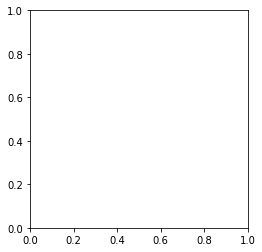

In [276]:
plt.imshow(X_train[0])
print(X_train[0].shape)
print(X_train.shape)

In [ ]:
X_train = np.where(X_train.reshape((X_train.shape[0], 224*224)) > 75, 1, 0) 
X_test = np.where(X_test.reshape((X_test.shape[0], 224*224)) > 75, 1, 0) 

In [ ]:
# convert X_train and X_test to binary
X_train = X_train.reshape((X_train.shape[0], 224, 224, 1))
X_test = X_test.reshape((X_test.shape[0], 224, 224, 1))

In [282]:
print(X_train[0].shape)
print(X_train.shape)

(224, 224, 3)
(471, 224, 224, 3)


In [ ]:
tm = MultiClassTsetlinMachine(3, 50, 10.0)

In [ ]:
print("\nAccuracy over 30 epochs:\n")
for i in range(30):
	start_training = time()
	tm.fit(X_train, y_train, epochs=1, incremental=True)
	stop_training = time()

	start_testing = time()
	result = 100*(tm.predict(X_test) == y_test).mean()
	stop_testing = time()

	print("#%d Accuracy: %.2f%% Training: %.2fs Testing: %.2fs" % (i+1, result, stop_training-start_training, stop_testing-start_testing))

In [ ]:
# remove color channel
X_train = X_train[:, :, :, 0]
X_test = X_test[:, :, :, 0]

In [ ]:
X_train[0].shape

In [ ]:
b = Binarizer(max_bits_per_feature = 10)
b.fit(X_train)
X_transformed = b.transform(X_train)

In [ ]:
# # convert to grayscale
# X_train = np.array([np.mean(x, axis=2) for x in X_train])
# X_test = np.array([np.mean(x, axis=2) for x in X_test])

In [ ]:
# X_train = np.where(X_train.reshape((X_train.shape[0], 224*224)) > 75, 1, 0) 
# X_test = np.where(X_test.reshape((X_test.shape[0], 224*224)) > 75, 1, 0) 

In [ ]:
plt.imshow(X_train[0])

In [ ]:
from pyTsetlinMachine.tm import MultiClassConvolutionalTsetlinMachine2D
import numpy as np

# train_data = np.loadtxt("2DNoisyXORTrainingData.txt")
# X_train = train_data[:,0:-1].reshape(train_data.shape[0], 4, 4)
# Y_train = train_data[:,-1]

# test_data = np.loadtxt("2DNoisyXORTestData.txt")
# X_test = test_data[:,0:-1].reshape(test_data.shape[0], 4, 4)
# Y_test = test_data[:,-1]

ctm = MultiClassConvolutionalTsetlinMachine2D(3, 50*100, 5.0, (224, 224), weighted_clauses=True)

ctm.fit(X_train, y_train, epochs=5)

# print("Accuracy:", 100*(ctm.predict(X_test) == y_test).mean())

# Xi = np.array([[[0,1,1,0],
# 		[1,1,0,1],
# 		[1,0,1,1],
# 		[0,0,0,1]]])

# print("\nInput Image:\n")
# print(Xi)
# print("\nPrediction: %d" % (ctm.predict(Xi)))

# print("\nAccuracy over 30 epochs:\n")
# for i in range(30):
# 	start = time()
# 	ctm.fit(X_train, y_train, epochs=1, incremental=True)
# 	stop = time()
	
# 	result = 100*(ctm.predict(X_test) == y_test).mean()
	
# 	print("#%d Accuracy: %.2f%% (%.2fs)" % (i+1, result, stop-start))

In [ ]:
ctm.fit(X_train, y_train, epochs=5)

In [ ]:
from keras.datasets import fashion_mnist
import cv2

(X_train, Y_train), (X_test, Y_test) = fashion_mnist.load_data()

In [ ]:
# X_train[0]

In [ ]:
X_train.shape[0]

In [ ]:
X_train = np.copy(X_train)
X_test = np.copy(X_test)

In [ ]:
X_train[0].shape

In [ ]:
X_train.shape[0]

In [ ]:
for i in range(X_train.shape[0]):
	X_train[i,:] = cv2.adaptiveThreshold(X_train[i], 1, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)

for i in range(X_test.shape[0]):
	X_test[i,:] = cv2.adaptiveThreshold(X_test[i], 1, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)

In [ ]:
X_train[0].shape

In [ ]:
X_train.shape[0]

In [ ]:
from pyTsetlinMachine.tm import MultiClassTsetlinMachine
import numpy as np
from time import time

from keras.datasets import mnist

(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

In [ ]:
plt.imshow(X_train[0])
print(X_train[0].shape)
print(X_train.shape)

In [ ]:
X_train = np.where(X_train.reshape((X_train.shape[0], 28*28)) > 75, 1, 0) 
X_test = np.where(X_test.reshape((X_test.shape[0], 28*28)) > 75, 1, 0) 

In [ ]:
plt.imshow(X_train[0])
print(X_train.shape)

## Build Fine-tuned DENSENET 121 model

In [ ]:
# # Attempt 1:

# densenet121_model = DenseNet121()

# for layer in densenet121_model.layers[:149]:
#     layer.trainable = False
# for layer in densenet121_model.layers[149:]:
#     layer.trainable = True

# model = Sequential()
# # add all layers but the last
# model.add(densenet121_model)
# # remove the last layer
# model.layers.pop()

# model.add(Dense(units=3, activation="softmax"))  #, name="predictions"))

In [ ]:
# # Attempt 2:

# def DenseNet121_Model():
#     # load the DenseNet121 network, ensuring the head FC layer sets are left off
#     baseModel = DenseNet121(
#         weights="imagenet",
#         include_top=False,
#         input_tensor=Input(shape=(224, 224, 3)),
#     )
#     # construct the head of the model that will be placed on top of the the base model
#     output = baseModel.output
#     output = AveragePooling2D(pool_size=(4, 4))(output)
#     output = Flatten(name="flatten")(output)
#     output = Dense(512, activation="relu")(output)
#     output = Dropout(0.25)(output)
#     output = Dense(3, activation="softmax")(output)
#     # place the head FC model on top of the base model (this will become the actual model we will train)
#     model = Model(inputs=baseModel.input, outputs=output)
#     # loop over all layers in the base model and freeze them so they will not be updated during the first training process
#     for layer in baseModel.layers:
#         layer.trainable = False
#     return model


# model = DenseNet121_Model()

In [ ]:
# # Attempt 3:

# # img_in = Input(t_x.shape[1:])
# img_in = Input(images[0].shape)
# model = DenseNet121(
#     include_top=False,
#     #layers=tf.keras.layers,
#     weights='imagenet',
#     input_tensor= img_in,
#     #input_shape= t_x.shape[1:],
#     input_shape = images[0].shape,
#     pooling ='avg'
#     )
# x = model.output
# predictions = Dense(3, activation="softmax", name="predictions")(x)
# model = Model(inputs=img_in, outputs=predictions)


In [ ]:
# input_shape = (IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)

# input_tensor = Input(shape=input_shape)

# densenet121_model = DenseNet121(
#     include_top=False,
#     weights='imagenet',
#     input_tensor=input_tensor,
#     input_shape=input_shape,
#     pooling=None,
#     classes=1000,
# )

# output = GlobalAveragePooling2D()(densenet121_model.output)

# prediction_layer = Dense(
#     units=3,
#     activation="softmax",
#     name="predictions",
# )(output)

# model = Model(inputs=densenet121_model.input, outputs=prediction_layer)

# for layer in model.layers[:-1]:
#     layer.trainable = False

input_shape = (IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)

input_tensor = Input(shape=input_shape)

# Load the DenseNet121 network, ensuring the head FC layer sets are left off.
densenet121_model = DenseNet121(
    include_top=False,
    weights='imagenet',
    input_tensor=input_tensor,
    input_shape=input_shape,
    pooling=None,
    classes=1000,
)

# Construct the head of the model that will be placed on top of the the base model.
output = AveragePooling2D(pool_size=(4, 4))(densenet121_model.output)
output = Flatten(name="flatten")(output)
output = Dense(512, activation="relu")(output)
output = Dropout(0.25)(output)

prediction_layer = Dense(
    units=3,
    activation="softmax",
    name="predictions",
)(output)

model = Model(inputs=densenet121_model.input, outputs=prediction_layer)

for layer in model.layers[:-14]:
    layer.trainable = False

In [ ]:
for layer in model.layers:
    if layer.trainable:
        print(layer.name)

In [ ]:
model.summary()
params = count_params(model)
# print(f"Trainable params: {params['trainable_params']:,}")
# print(f"Non-trainable params: {params['non_trainable_params']:,}")
# assert params['trainable_params'] == 6_956_931
# assert params['non_trainable_params'] == 83_648

## Compile model

In [ ]:
model.compile(
    optimizer=Adam(
        learning_rate=0.001,  # (0.001 * np.sqrt(0.1)),
        beta_1=0.9,
        beta_2=0.999,
        epsilon=1e-08,
        amsgrad=False,
        name="Adam",
    ),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

## Fit model

In [ ]:
epochs = 50

set_callbacks = [  # None
    # "lr_schedule",
    "lr_plateau",
    "early_stopping",
    "model_checkpoint",
]

if "lr_schedule" in set_callbacks and "lr_plateau" in set_callbacks:
    set_callbacks.pop(set_callbacks.index("lr_plateau"))
    print("Note: 'LearningRateScheduler' always wins over 'ReduceLROnPlateau'\n")

callbacks = []
callback_names = []

if set_callbacks:
    if "lr_schedule" in set_callbacks:
        learning_rate_schedule = learning_rate_scheduler(
            # epoch_steps=[5, 20],  # None,
            initial_lr=round(float(model.optimizer.learning_rate.numpy()), 8),
            # lr_steps=[0.1, 0.1],  # None,
            # use_factor=True,
            verbose=1
        )
        lr_schedule = LearningRateScheduler(learning_rate_schedule)
        model.optimizer.learning_rate = learning_rate_schedule(0)
        print(
            "[LR SCHEDULE]:\n"
            f"\tEpoch_steps: {getattr(learning_rate_schedule, 'epoch_steps')}\n"
            f"\tInitial_lr: {getattr(learning_rate_schedule, 'initial_lr')}\n"
            f"\tLr_steps: {getattr(learning_rate_schedule, 'lr_steps')}\n"
            f"\tUse_factor: {getattr(learning_rate_schedule, 'use_factor')}\n"
            )
        if getattr(learning_rate_schedule, 'use_factor'):
            epcs = getattr(learning_rate_schedule, 'epoch_steps')
            curr_step = round(float(model.optimizer.learning_rate.numpy()), 8)
            print(str(f"\tEpoch 0: {curr_step:.10f}").rstrip("0"))
            for i, step in enumerate(getattr(learning_rate_schedule, 'lr_steps')):
                curr_step *= step
                print(str(f"\tEpoch {epcs[i]}: {curr_step:.10f}").rstrip("0"))
            print()

        callbacks.append(lr_schedule)
        callback_names.append("lr_schedule")

    if "lr_plateau" in set_callbacks:
        lr_plateau = ReduceLROnPlateau(
            monitor="val_loss",
            factor=np.sqrt(0.1),
            patience=2,
            verbose=1,
            mode="auto",
            # min_delta=0.01,
            cooldown=0,
            min_lr=0.5e-6,
        )
        callbacks.append(lr_plateau)
        callback_names.append("lr_plateau")

    if "early_stopping" in set_callbacks:
        early_stopping = EarlyStopping(
            monitor="val_loss",
            # min_delta=0.01,
            patience=6,
            verbose=1,
            mode="auto",
            baseline=None,
            restore_best_weights=True,
        )
        callbacks.append(early_stopping)
        callback_names.append("early_stopping")

    if "model_checkpoint" in set_callbacks:
        model_checkpoint = ModelCheckpoint(
            filepath=p_join(MODELS_PATH, MODEL_NAME + "_" + "checkpoint.hdf5"),
            monitor="val_loss",
            verbose=1,
            save_best_only=True,
            save_weights_only=False,
            mode="auto",
            save_freq="epoch",
            options=None,
        )
        callbacks.append(model_checkpoint)
        callback_names.append("model_checkpoint")

print(f"Selected callbacks: {enumerate_oxford(callback_names)}")

In [ ]:
TRAIN_STEPS_PER_EPOCH = int(train_gen.n / BATCH_SIZE)
VALID_STEPS_PER_EPOCH = int(valid_gen.n / BATCH_SIZE)
print("Train steps per epoch:", TRAIN_STEPS_PER_EPOCH)
print("Valid steps per epoch:", VALID_STEPS_PER_EPOCH)

In [ ]:
model_operation = "fit"

mkdir_if_not_exists(MODELS_PATH)

clear_session()

if model_operation == "fit":
    history = model.fit(
        x=train_gen,
        epochs=epochs,
        steps_per_epoch=TRAIN_STEPS_PER_EPOCH,
        validation_data=valid_gen,
        validation_steps=VALID_STEPS_PER_EPOCH,
        verbose=2,
        callbacks=callbacks if len(callbacks) > 0 else None,
        # workers=2,
    )

    save_model(model, os.path.join(MODELS_PATH, f"{MODEL_NAME}_model.h5"))

    # save model history
    pickler(
        os.path.join(MODELS_PATH, f"{MODEL_NAME}_model_history"),
        "save",
        history,
    )

elif model_operation == "load":
    model = load_model(os.path.join(MODELS_PATH, f"{MODEL_NAME}_model.h5"))
    history = pickler(
        os.path.join(MODELS_PATH, f"{MODEL_NAME}_model_history"), "load"
    )

elif model_operation == "checkpoint":
    model = load_model(
        os.path.join(MODELS_PATH, f"{MODEL_NAME}_checkpoint.hdf5")
    )
    history = None

## Predict

In [ ]:
predictions, y_pred, y_true, target_names = predict_gen(model=model, gen=test_gen)

In [ ]:
predictions[0:5]

In [ ]:
y_pred

In [ ]:
y_true

In [ ]:
target_names

In [ ]:
compare_predictions(y_pred, y_true, target_names)

In [ ]:
print(f"normal: {TEST_NORMAL_FILES[2]}")
print(f"lgg: {TEST_LGG_FILES[8]}")
print(f"hgg: {TEST_HGG_FILES[17]}")

In [ ]:
predictor(
    # path="/Users/lewiuberg/Documents/Data Science/Projects/tumorclass.info/data/dataset/test/lgg/33.jpg",
    path=p_join(TEST_PATH, "normal", "1.jpg"),
    image_width=IMAGE_WIDTH,
    image_height=IMAGE_HEIGHT,
    model=model,
    classes=CLASSES,
)

In [ ]:
predictor(
    # path="/Users/lewiuberg/Documents/Data Science/Projects/tumorclass.info/data/dataset/test/lgg/33.jpg",
    path=p_join(TEST_PATH, "lgg", "21.jpg"),
    image_width=IMAGE_WIDTH,
    image_height=IMAGE_HEIGHT,
    model=model,
    classes=CLASSES,
)

In [ ]:
predictor(
    # path="/Users/lewiuberg/Documents/Data Science/Projects/tumorclass.info/data/dataset/test/lgg/33.jpg",
    path=p_join(TEST_PATH, "hgg", "58.jpg"),
    image_width=IMAGE_WIDTH,
    image_height=IMAGE_HEIGHT,
    model=model,
    classes=CLASSES,
)

## Evaluate

In [ ]:
eval_loss, eval_accuracy = model.evaluate(
    x=test_gen,
    batch_size=BATCH_SIZE,
    verbose=1
)

print(f"Evaluation loss: {eval_loss:.2f}")
print(f"Evaluation accuracy: {eval_accuracy*100:.2f}%")

In [ ]:
if history is not None:
    plot_epochs(
        history=history,
        filepath=f"{MODELS_PATH}{MODEL_NAME}",
        plot_lr=2,
        lr_x_offset=0.45,
        lr_y_offset=0.095,
        scale=1000,
    )

In [ ]:
cm = confusion_matrix(
    y_pred=y_pred,
    y_true=y_true,
    labels=CLASSES,
    save=True,
    path=MODELS_PATH,
    file_name=MODEL_NAME,
)

In [ ]:
cm.imbalance

In [ ]:
# print four lines. Justify text after colon
print(
    f"{'Accuracy':<10} {'Precision':<10} {'Recall':<10} {'F1 Score':<10}\n"
    f"{cm.Overall_ACC*100:<10.2f} {cm.PPV_Macro:<10.2f}"
    f"{cm.TPR_Macro:<10.2f} {cm.F1_Macro:<10.2f}"
)

In [ ]:
cm.plot(plot_lib = "seaborn", number_label=True)

In [ ]:
cm.plot(plot_lib = "seaborn", number_label=True, normalized=True)

In [ ]:
print('\nAccuracy: {:.2f}\n'.format(accuracy_score(y_true, y_pred)))

print('Micro Precision: {:.2f}'.format(precision_score(y_true, y_pred, average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(y_true, y_pred, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(y_true, y_pred, average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(y_true, y_pred, average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(y_true, y_pred, average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(y_true, y_pred, average='macro')))

print('Weighted Precision: {:.2f}'.format(precision_score(y_true, y_pred, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(y_true, y_pred, average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(y_true, y_pred, average='weighted')))

print('\nClassification Report\n')
print(classification_report(y_true=y_true, y_pred=y_pred, target_names=target_names))